# imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# datasets

In [2]:
# Reading the data
df = pd.read_csv("spam.csv",encoding='latin-1')
df.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# data preprocessing

In [3]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns={'v1':'label','v2':'Text'})
df['label_enc'] = df['label'].map({'ham':0,'spam':1})
df.head()


,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


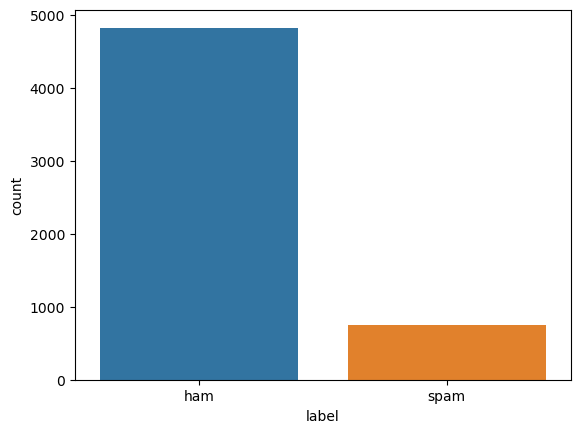

In [4]:
sns.countplot(x=df['label'])
plt.show()


In [5]:
# Find average number of tokens in all sentences
avg_words_len=round(sum([len(i.split()) for i in df['Text']])/len(df['Text']))
print(avg_words_len)


15


In [7]:
# Finding Total no of unique words in corpus
s = set()
for sent in df['Text']:
    for word in sent.split():
        s.add(word)
total_words_length=len(s)
print(total_words_length)


15585


# train-test split

In [8]:
# Splitting data for Training and testing
from sklearn.model_selection import train_test_split

X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_enc'])
new_df = pd.DataFrame({'Text': X, 'label': y})
X_train, X_test, y_train, y_test = train_test_split(
	new_df['Text'], new_df['label'], test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((4457,), (4457,), (1115,), (1115,))

# building model

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score

tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec,X_test_vec = tfidf_vec.transform(X_train),tfidf_vec.transform(X_test)

baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec,y_train)


MultinomialNB()

In [25]:
nb_accuracy=accuracy_score(y_test,baseline_model.predict(X_test_vec))
print(nb_accuracy)
print(classification_report(y_test,baseline_model.predict(X_test_vec)))

0.9623318385650225
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.72      0.84       150

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



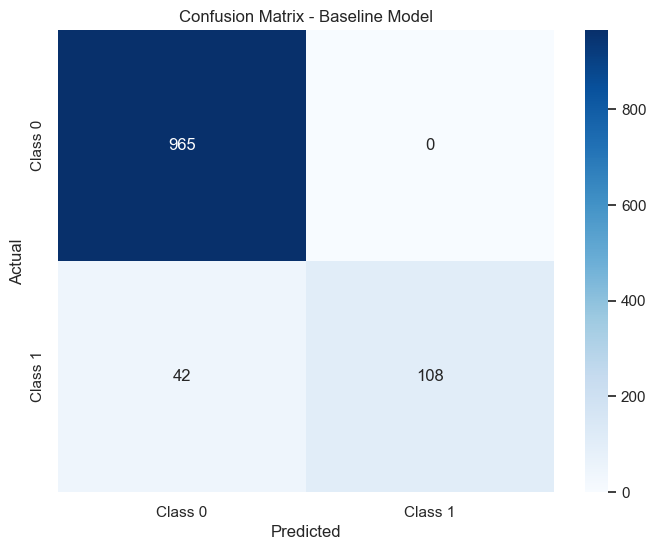

In [28]:
# from sklearn.metrics import plot_confusion_matrix
# plot_confusion_matrix(baseline_model,X_test_vec,y_test)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'baseline_model' is your trained model and 'X_test_vec' and 'y_test' are your test data
y_pred = baseline_model.predict(X_test_vec)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Baseline Model')
plt.show()




In [10]:
from tensorflow.keras.layers import TextVectorization

MAXTOKENS=total_words_length
OUTPUTLEN=avg_words_len

text_vec = TextVectorization(
	max_tokens=MAXTOKENS,
	standardize='lower_and_strip_punctuation',
	output_mode='int',
	output_sequence_length=OUTPUTLEN
)
text_vec.adapt(X_train)


2023-08-14 18:24:17.453174: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-08-14 18:24:17.453224: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-08-14 18:24:17.453237: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-08-14 18:24:17.453504: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-14 18:24:17.453530: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-08-14 18:24:17.563332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [29]:
sample_sentence='this is a message'
text_vec([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 41,  10,   5, 148,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [11]:
embedding_layer = layers.Embedding(
	input_dim=MAXTOKENS,
	output_dim=128,
	embeddings_initializer='uniform',
	input_length=OUTPUTLEN
)


In [12]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)

model_1.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(
	label_smoothing=0.5), metrics=['accuracy'])


In [30]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 128)           1994880   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128  

In [31]:
history_1=model_1.fit(X_train,y_train,epochs=5,validation_data=(X_test,y_test),validation_steps=int(0.2*len(X_test)))

Epoch 1/5


2023-08-14 19:14:09.963117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


140/140 [==============================] - ETA: 0s - loss: 0.5912 - accuracy: 0.9648

2023-08-14 19:14:13.664314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


140/140 [==============================] - 5s 29ms/step - loss: 0.5912 - accuracy: 0.9648 - val_loss: 0.5776 - val_accuracy: 0.9821
Epoch 2/5
140/140 [==============================] - 3s 23ms/step - loss: 0.5692 - accuracy: 0.9964 - val_loss: 0.5765 - val_accuracy: 0.9830
Epoch 3/5
140/140 [==============================] - 3s 21ms/step - loss: 0.5668 - accuracy: 0.9987 - val_loss: 0.5762 - val_accuracy: 0.9839
Epoch 4/5
140/140 [==============================] - 3s 21ms/step - loss: 0.5656 - accuracy: 0.9991 - val_loss: 0.5759 - val_accuracy: 0.9839
Epoch 5/5
140/140 [==============================] - 3s 21ms/step - loss: 0.5649 - accuracy: 0.9993 - val_loss: 0.5760 - val_accuracy: 0.9857


<Axes: >

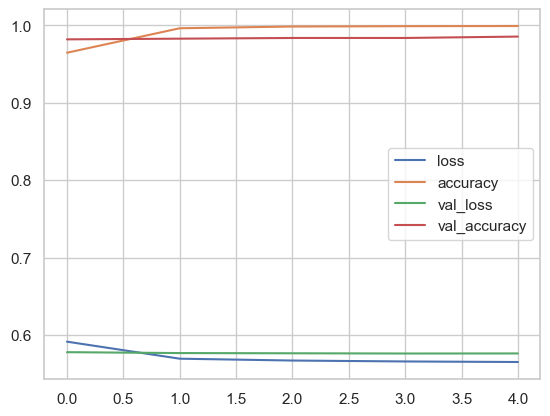

In [32]:
pd.DataFrame(history_1.history).plot()

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compile_model(model):
	'''
	simply compile the model with adam optimzer
	'''
	model.compile(optimizer=keras.optimizers.Adam(),
				loss=keras.losses.BinaryCrossentropy(),
				metrics=['accuracy'])

def fit_model(model, epochs, X_train=X_train, y_train=y_train,
			X_test=X_test, y_test=y_test):
	'''
	fit the model with given epochs, train
	and test data
	'''
	history = model.fit(X_train,
						y_train,
						epochs=epochs,
						validation_data=(X_test, y_test),
						validation_steps=int(0.2*len(X_test)))
	return history

def evaluate_model(model, X, y):
	'''
	evaluate the model and returns accuracy,
	precision, recall and f1-score
	'''
	y_preds = np.round(model.predict(X))
	accuracy = accuracy_score(y, y_preds)
	precision = precision_score(y, y_preds)
	recall = recall_score(y, y_preds)
	f1 = f1_score(y, y_preds)

	model_results_dict = {'accuracy': accuracy,
						'precision': precision,
						'recall': recall,
						'f1-score': f1}

	return model_results_dict


In [14]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
bi_lstm = layers.Bidirectional(layers.LSTM(
	64, activation='tanh', return_sequences=True))(embedding_layer_model)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout = layers.Dropout(.1)(flatten)
x = layers.Dense(32, activation='relu')(dropout)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_2 = keras.Model(input_layer, output_layer)

compile_model(model_2) # compile the model
history_2 = fit_model(model_2, epochs=5) # fit the model


Epoch 1/5


2023-08-14 18:25:13.373165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-14 18:25:13.940352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-14 18:25:13.963147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-14 18:25:14.434540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-14 18:25:14.451476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-14 18:25:16.038433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-14 18:25:16.064473: I tensorflow/core/grappler/optimizers/cust

140/140 [==============================] - ETA: 0s - loss: 0.1585 - accuracy: 0.9426

2023-08-14 18:25:24.212284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-14 18:25:24.369261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-14 18:25:24.382259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-14 18:25:24.592211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-14 18:25:24.604811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


140/140 [==============================] - 16s 75ms/step - loss: 0.1585 - accuracy: 0.9426 - val_loss: 0.0849 - val_accuracy: 0.9776
Epoch 2/5
140/140 [==============================] - 8s 57ms/step - loss: 0.0243 - accuracy: 0.9924 - val_loss: 0.1016 - val_accuracy: 0.9785
Epoch 3/5
140/140 [==============================] - 8s 55ms/step - loss: 0.0094 - accuracy: 0.9973 - val_loss: 0.0888 - val_accuracy: 0.9794
Epoch 4/5
140/140 [==============================] - 8s 54ms/step - loss: 8.1995e-04 - accuracy: 0.9998 - val_loss: 0.1447 - val_accuracy: 0.9803
Epoch 5/5
140/140 [==============================] - 8s 54ms/step - loss: 3.2128e-05 - accuracy: 1.0000 - val_loss: 0.1520 - val_accuracy: 0.9803


In [16]:
baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test)
model_1_results = evaluate_model(model_1, X_test, y_test)
model_2_results = evaluate_model(model_2, X_test, y_test)
# model_3_results = evaluate_model(model_3, X_test, y_test)

total_results = pd.DataFrame({'MultinomialNB Model':baseline_model_results,
							'Custom-Vec-Embedding Model':model_1_results,
							'Bidirectional-LSTM Model':model_2_results,}).transpose()

total_results


 1/35 [..............................] - ETA: 9s

2023-08-14 18:28:48.412474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 0s 6ms/step


2023-08-14 18:28:49.240292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-14 18:28:49.384416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-14 18:28:49.397086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 4/35 [==>...........................] - ETA: 0s 

2023-08-14 18:28:49.504118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-14 18:28:49.517128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 1s 17ms/step


,accuracy,precision,recall,f1-score
MultinomialNB Model,0.962332,1.000000,0.720000,0.837209
Custom-Vec-Embedding Model,0.310314,0.096480,0.493333,0.161396
Bidirectional-LSTM Model,0.980269,0.957143,0.893333,0.924138


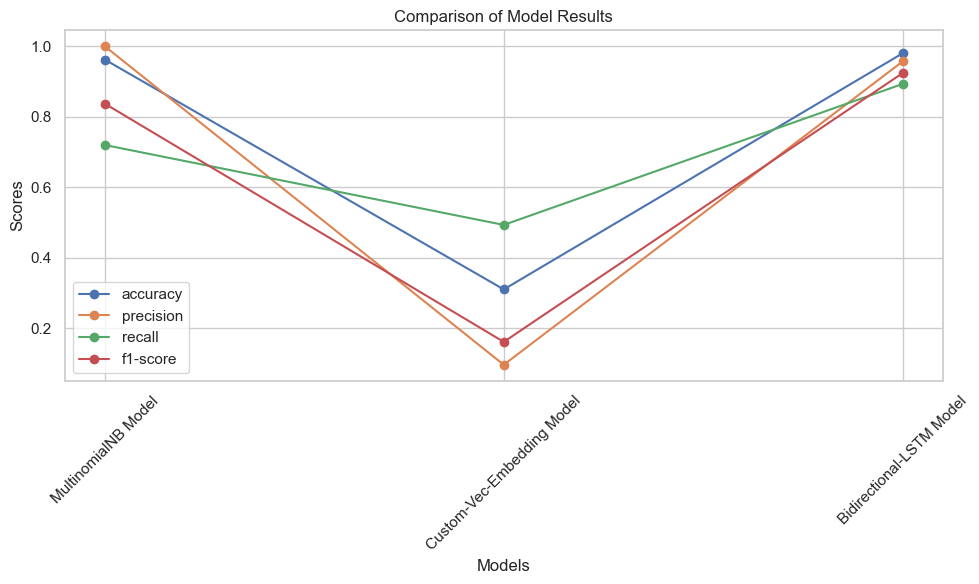

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Your code to calculate results and create the total_results DataFrame
# ...

# Plotting the line graph comparison
plt.figure(figsize=(10, 6))

metrics = total_results.columns

for metric in metrics:  # Loop through each metric
    plt.plot(total_results.index, total_results[metric], marker='o', label=metric)

plt.title('Comparison of Model Results')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()

plt.show()  # Display the graph
